# Maizeを利用してSBVSの前処理とドッキングシミュレーションを実行する



## 生成モデルから発生させた構造を確認する

SBVSを実施する前に構造を確認します。コードの詳細は割愛します。

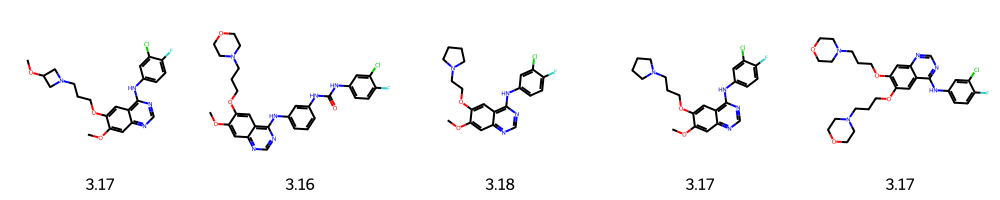

In [ ]:
#import setenv # XDG_CONFIG_HOMEの設定がうまく行かない場合
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

df = pd.read_csv('./TL_sampling.csv')
smiles_lst = [row['SMILES'] for idx, row in df.iterrows()]
# used first
smiles_lst = [s for s in smiles_lst][1:6]

mols = [Chem.MolFromSmiles(smi) for smi in smiles_lst]
Draw.MolsToGridImage(mols[:6], legends=[str(nll) for nll in df.NLL][:6], molsPerRow=5)

## Maizeのワークフローを構築する

XXで設定したtomlファイルからGypsumとAutoDock Vina用のノードを追加します。

In [2]:
from pathlib import Path
from maize.core.workflow import Workflow
from maize.steps.io import LoadData, LogResult, Return
import os, sys

from maize.steps.mai.docking.adv import Vina
from maize.steps.mai.molecule import Gypsum
from maize.utilities.chem import IsomerCollection

In [4]:
flow = Workflow(name='dock', level='info', cleanup_temp=True)
load = flow.add(LoadData[list[str]])
#void = flow.add(Void)
# 3D conf gen and protonate
embe = flow.add(Gypsum)
# run vina docking
dock = flow.add(Vina)
# receive docke results
retu = flow.add(Return[list[IsomerCollection]])

### AutoDock Vinaの設定

ドッキングシミュレーションの設定をします。ハンズオンでは説明しませんので詳細はAutoDock Vinaのドキュメントを参照してください。

In [5]:
load.data.set(smiles_lst)
embe.n_variants.set(2)
embe.timeout.set(10)
# EGFR <https://www.rcsb.org/structure/2ITO>
dock.receptor.set(Path('/home/iwatobipen/dev/CBI/cheminfo_tutorial_20241028_pub/data/2ito_fix_remh.pdbqt'))
dock.search_center.set((-56.643,  -6.844, -23.487))
dock.search_range.set((20.00, 20.00, 20.00))
# default vaule 8 seems too small ...
dock.exhaustiveness.set(16)

### 最後にノードを接続します。

In [6]:
flow.connect(load.out, embe.inp)
flow.connect(embe.out, dock.inp)
flow.connect(dock.out,retu.inp)
flow.check()

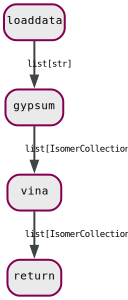

In [7]:
flow.visualize() # ワークフローを視覚化

In [8]:
flow.execute() #実行

2024-10-28 15:59:33,762 |     INFO |             dock | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-28 15:59:33,763 |     INFO |             dock | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-28 15:5

2024-10-28 15:59:37,171 |     INFO |             dock | Node 'gypsum' finished (2/4)


2024-10-28 16:01:51,734 |     INFO |             vina | Job completed (1/7)


2024-10-28 16:02:30,474 |     INFO |             vina | Job completed (2/7)


2024-10-28 16:02:53,176 |     INFO |             vina | Job completed (3/7)
2024-10-28 16:02:53,344 |     INFO |             vina | Job completed (4/7)


2024-10-28 16:03:08,254 |     INFO |             vina | Job completed (5/7)


2024-10-28 16:05:39,383 |     INFO |             vina | Job completed (6/7)


2024-10-28 16:06:02,014 |     INFO |             vina | Job completed (7/7)
2024-10-28 16:06:02,031 |     INFO |             dock | Workflow status
                                   |           gypsum | COMPLETED
                                   |         loaddata | COMPLETED
                                   |             vina | RUNNING
                                   |           return | WAITING_FOR_INPUT
2024-10-28 16:06:02,022 |     INFO |             vina | Parsing isomer 0: 'PCOJXJDERCUUJF-LSJXVMLKNA-O'
2024-10-28 16:06:02,033 |     INFO |             vina | Parsing isomer 1: 'FOUAIICDWNVJON-WVRSUYCFNA-N'
2024-10-28 16:06:02,036 |     INFO |             vina | Parsing isomer 2: 'BLFAAYGECSULMU-HXTKINSTNA-N'
2024-10-28 16:06:02,037 |     INFO |             vina | Parsing isomer 3: 'XGPAXWVNLWKLEF-YYUQPUGGNA-O'
2024-10-28 16:06:02,039 |     INFO |             vina | Parsing isomer 4: 'FLMFUGCILGIYEN-NSJMMFDCNA-N'
2024-10-28 16:06:02,050 |     INFO |             dock | Node '

2024-10-28 16:06:02,544 |     INFO |             dock | Node 'vina' finished (4/4)
2024-10-28 16:06:03,047 |     INFO |             dock | Execution completed :) total runtime: 0:06:28.760872
	4 nodes completed successfully
	0 nodes stopped due to closing ports
	0 nodes failed
	0:13:00.358352 total walltime
	0:06:32.363912 spent waiting for resources or other nodes


### Docking後のファイルを保存
- 以下のコードでは dock_resというフォルダを作成しデータを保存する作業をします。
- Return Nodeからデータをget()で取得後ループを回して分子を保存します。
- 各オブジェクトはto_sdfメソッドを利用するとSDFとして保存できますので最初に作成したディレクトリに保存していきます。

In [9]:
!mkdir dock_res

In [ ]:
res=retu.get()

from pathlib import Path
for midx, ms in enumerate(res):
    for cidx, m in enumerate(ms.molecules):
        m.to_sdf(Path(f'./dock_res/ok_{midx}_{cidx}.sdf'))

In [11]:
res[0].molecules[1]

Isomer(n_atoms=56, n_conformers=1, charge=1, free_energy=-7.8030)